# Stat 426 Machine Learning Project: Flash Floods in Utah

## Introduction

The data I am using for this project comes from the NOAA (National Oceanic and Atmospheric Administration). The data is accessible through NOAA's National Centers for Environmental Information (NCEI). For reference, the data I will be using is aggregated from a list of csv files that I accessed through the NCEI. The files are found at this url: https://www1.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/legacy/. Information about the dataset and variables gathered can be found at https://www1.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/Storm-Data-Export-Format.pdf. The data ranges from 1996 to 2013, but for simplicity, I have accessed only the data from 2007 to 2013. These files have information about a variety of weather-related events, such as wildfires, landslides, hurricanes, tsunamis, and even rip currents. I have decided to focus my project on flash flooding. Specifically, I am interested in flash floods in Utah. I know that Southern Utah is very prone to flooding, so I'm interested to see if the volume of flash floods is significantly greater in the southern portion of the state compared to the north. 

The goals of this analysis are to use various factors such as length (in hours), distance (in miles), day of the month, and flood cause (most of the flash floods are caused by rain) to see whether we can classify whether or not there was property damage from the flood.

A potential further analysis would be to expand the model to a certain region or combine types of events (for example hurricanes and tsunamis) in a type of aggregate analysis.



## Data Import and Cleaning

My process of getting this data included aggregating the csv files found on the website linked above. I then created variables such as distance and duration from these variables, the process of which is seen below. There was a relatively large amount of data cleaning involved in this project because the raw CSV data was a bit untidy.

In [1]:
import pandas as pd
import numpy as np 
import requests
from tqdm import tqdm_notebook as tqdm #this allows me to create progress bars for time-consuming loops
import json
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

In [6]:
#create a list of the filenames that I'm reading in from the NOAA webpage
years1 = list(range(2007,2010))
years2 = list(range(2010,2014))

all_files = []
for i in years1:
    url = 'https://www1.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/legacy/Stormdata_' + str(i) +'.csv'
    all_files.append(url)
for i in years2: 
    url = 'https://www1.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/legacy/stormdata_' + str(i) +'.csv'
    all_files.append(url)

In [7]:
all_files

['https://www1.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/legacy/Stormdata_2007.csv',
 'https://www1.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/legacy/Stormdata_2008.csv',
 'https://www1.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/legacy/Stormdata_2009.csv',
 'https://www1.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/legacy/stormdata_2010.csv',
 'https://www1.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/legacy/stormdata_2011.csv',
 'https://www1.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/legacy/stormdata_2012.csv',
 'https://www1.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/legacy/stormdata_2013.csv']

In [8]:
##READ IN DATA FROM WEB: (note that adding more files significantly increases the runtime of this loop)
li = []

for filename in tqdm(all_files):
    df = pd.read_csv(filename, index_col=None, header=0,encoding="cp1252",dtype={'SOURCE':object,'MAGNITUDE_TYPE':object,"EVENT_NARRATIVE":object})
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

In [10]:
#select only the data about flash floods in Utah:
flood = frame[frame.EVENT_TYPE == 'Flash Flood']
utah = flood[flood.STATE == 'UTAH']
utah = utah.dropna(axis=1,how='all') #drop columns that are entirely missing values
deaths = utah.EPISODE_NARRATIVE[utah.DEATHS_DIRECT != 0].tolist() #narratives of floods that led to fatalities

In [11]:
#Get the coordinates of the start and end locations of the flood

#create a dataframe of the beginning latitudes and longitudes
b_lat_long = pd.DataFrame([utah.BEGIN_LAT,utah.BEGIN_LON]).transpose()
b_lat_long = b_lat_long.rename(columns={'BEGIN_LON':'beginlong','BEGIN_LAT':'beginlat'})
b_lat_long['location'] = list(zip(b_lat_long.beginlat, b_lat_long.beginlong)) #combine them in a tuple and append to list
#create a dataframe of the ending latitudes and longitudes
e_lat_long = pd.DataFrame([utah.END_LAT,utah.END_LON]).transpose()
e_lat_long = e_lat_long.rename(columns={'END_LON':'endlong','END_LAT':'endlat'})
e_lat_long['location'] = list(zip(e_lat_long.endlat,e_lat_long.endlong)) #combine them in a tuple and append to list

begin_coords = b_lat_long.location 
end_coords = e_lat_long.location


In [487]:
#decide which columns I actually care about:
my_data = utah.filter(['BEGIN_DAY','BEGIN_TIME','END_DAY','END_TIME','YEAR','MONTH_NAME','INJURIES_DIRECT','INJURIES_INDIRECT','DEATHS_DIRECT','DEATHS_INDIRECT','DAMAGE_PROPERTY','DAMAGE_CROPS','SOURCE','FLOOD_CAUSE','BEGIN_RANGE','BEGIN_LOCATION','CZ_NAME','BEGIN_LAT','BEGIN_LON','END_LAT','END_LON','EPISODE_NARRATIVE','EVENT_NARRATIVE','BEGIN_YEARMONTH','END_YEARMONTH'])

#add coordinates to dataframe
my_data['begin_coords'] = begin_coords
my_data['end_coords'] = end_coords

In [488]:
#change damage amounts to numeric:
property_damage = []
for i in range(0,len(utah)):
    if utah.DAMAGE_PROPERTY.tolist()[i].endswith("K"):
        property_damage.append(float(utah.DAMAGE_PROPERTY.tolist()[i].split("K")[0])*1000) #if the string ends with K, x1000
    else: property_damage.append(float(utah.DAMAGE_PROPERTY.tolist()[i].split("M")[0])*1000000) #if the string ends with M,  x100000


crop_damage = []
for i in range(0,len(utah)):
    if utah.DAMAGE_CROPS.tolist()[i].endswith("K"):
        crop_damage.append(float(utah.DAMAGE_CROPS.tolist()[i].split("K")[0])*1000) #if the string ends with K, x1000
    else: crop_damage.append(float(utah.DAMAGE_CROPS.tolist()[i].split("M")[0])*1000000) #if the string ends with M,  x100000
        
my_data['DAMAGE_PROPERTY'] = property_damage
my_data['DAMAGE_CROPS'] = crop_damage

In [489]:
#change start and end dates to be of the format YYYYMMDDmmss

#change begin_yearmonth,begin_day,begin_time,end_yearmonth,endday, and endtime to strings
yearmonth = utah.BEGIN_YEARMONTH.astype(str)
beginday = utah.BEGIN_DAY.astype(str)
begintime = utah.BEGIN_TIME.astype(str)
yearmonth2 = utah.END_YEARMONTH.astype(str)
endday = utah.END_DAY.astype(str)
endtime = utah.END_TIME.astype(str)



In [490]:
#make sure all time ojects are of the form YYYYMMDDhhmm
#note: I used lots of for loops for this. I'm sure there is a better way to do it, but I didn't have time to figure it out 
for i in range(0,len(beginday)):
    if len(beginday.iloc[i]) != 2:
        beginday.iloc[i] = '0' + beginday.iloc[i]
    else: beginday.iloc[i] = beginday.iloc[i]
        
for i in range(0,len(endday)):
    if len(endday.iloc[i]) != 2:
        endday.iloc[i] = '0' + endday.iloc[i]
    else: endday.iloc[i] = endday.iloc[i]
        
for i in range(0,len(begintime)):
    if len(begintime.iloc[i]) == 1:
        begintime.iloc[i] = '000' + begintime.iloc[i]
    elif len(begintime.iloc[i]) == 2:
        begintime.iloc[i] = '00' + begintime.iloc[i]
    elif len(begintime.iloc[i]) == 3: 
        begintime.iloc[i] = '0' + begintime.iloc[i]
    else: begintime.iloc[i] = begintime.iloc[i]       

for i in range(0,len(endtime)):
    if endtime.iloc[i] == '0':
        endtime.iloc[i] = '0000'
    elif len(endtime.iloc[i]) == 1:
        endtime.iloc[i] == '000' + endtime.iloc[i]
    elif len(endtime.iloc[i]) == 2:
        endtime.iloc[i] = '00' + endtime.iloc[i]
    elif len(endtime.iloc[i]) == 3: 
        endtime.iloc[i] = '0' + endtime.iloc[i]
    else: endtime.iloc[i] = endtime.iloc[i]

begindate = list(yearmonth + beginday + begintime)
enddate = list(yearmonth2 + endday + endtime)



In [491]:
from datetime import datetime

duration = []
for i in tqdm(range(0,len(utah))):
    b_year = int(yearmonth.tolist()[i][:-2])
    b_mo = int(yearmonth.tolist()[i][-2:])
    b_day = int(beginday.tolist()[i])
    b_hr = int(begintime.tolist()[i][:-2])
    b_min = int(begintime.tolist()[i][-2:])
    b_sec = 0

    e_year = int(yearmonth2.tolist()[i][:-2])
    e_mo = int(yearmonth2.tolist()[i][-2:])
    e_day = int(endday.tolist()[i])
    e_hr = int(endtime.tolist()[i][:-2])
    e_min = int(endtime.tolist()[i][-2:])
    e_sec = 0

    start = datetime(b_year,b_mo,b_day,b_hr,b_min,b_sec) #start datetime
    end  = datetime(e_year,e_mo,e_day,e_hr,e_min,e_sec) #end datetime
    d = end - start                      
    d = d.total_seconds() 

    duration.append(d/3600)
    
#add variable to dataframe
my_data['duration'] = duration

#NOTE: If duration is 0, that means the flood lasted for less than an hour,maybe even less than a minute. however, the data is probably innacurate. 
#should I just drop these rows? there are 7 of them..

In [770]:
model_data.columns

Index(['BEGIN_DAY', 'END_DAY', 'YEAR', 'MONTH_NAME', 'INJURIES_DIRECT',
       'INJURIES_INDIRECT', 'DEATHS_DIRECT', 'DEATHS_INDIRECT', 'SOURCE',
       'FLOOD_CAUSE', 'BEGIN_RANGE', 'BEGIN_LOCATION', 'CZ_NAME', 'duration',
       'flood_distance', 'large_prop_damage'],
      dtype='object')

I was interested in seeing whether I could figure out how far a flood traveled using the latitudes and longitudes. The Haversine formula calculates the curved distance between two points on a sphere given the start and end coordinates, so I found a github page that had this formula coded in Python already. The url of the github: https://gist.github.com/rochacbruno/2883505I. Used his function to calculate the distance that each flood traveled.  

In [492]:
#find the distances that each flood travelled (if possible, some of the end locations are missing)
my_data['END_LAT'] = my_data.END_LAT.fillna('na') 
my_data['END_LON'] = my_data.END_LON.fillna('na')

#define a function to find the distance between lat/long pairs
#the following is not my code, I borrowed this function directly from a github page
# Haversine formula example in Python
# Author: Wayne Dyck
import math
def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c
    
    return d

#create a list of the distances (in miles)
distance_list = []
for i in range(0,len(begin_coords)):
    distance_list.append(distance(origin = begin_coords.tolist()[i],destination=end_coords.tolist()[i]))
    
#add variable to dataframe
my_data['flood_distance'] = distance_list

In [493]:
#drop some columns that I won't need for analysis
my_data = my_data.drop(columns = ['BEGIN_YEARMONTH','END_YEARMONTH','BEGIN_LAT','BEGIN_LON','END_LAT','END_LON'])
my_data.drop(my_data[my_data['duration'] == 0].index, inplace=True) #drop 7 rows that have flood duration = 0

In [20]:
###TO DO: Drop rows where duration = 0 and redo the google images change the image file screenshot

## Exploratory Data Analysis

The following code allows me to map the starting locations of the flash floods in Utah from 2007-2013. An individual API key must be created in order to run the code, so the code is commented and an image of the output is displayed below the commented code. Instructions to create a Google Maps API key is at the following url: https://developers.google.com/maps/documentation/embed/get-api-key. I will first map the starting flash flood locations with points, and then I will illustrate how to build a heatmap that shows where the highest density of flash floods is located in Utah. As seen on the heatmap below, it seems like there is a higher density of flash floods in the South-West corner of the State. This is not surprising, as the Southern Utah area frequently experiences flash floods in the canyons of Zion National Park, Snow Canyon (near St. George), and the Virgin river area. 

In [21]:
#map the latitudes and longitudes 
import requests
import gmaps
import json
from gmplot import gmplot
gmaps.configure(api_key="YOUR API KEY HERE") 

In [22]:
#plot the start locations of the floods on a map
#center_coords = (39.42,-111.73) #center the base map 
#fig = gmaps.figure(map_type="ROADMAP",center=center_coords, zoom_level=6)
#fig.add_layer(gmaps.symbol_layer(b_lat_long['location'],fill_color='red',stroke_color='red')) 
#fig

![alt text](Roadmap.png "Start Locations of Flash Floods in Utah")

In [23]:
#locations = b_lat_long['location']
#c_coords = (39.4,-111)
#fig = gmaps.figure(map_type='HYBRID',center=c_coords,zoom_level=6.2)
#heatmap_layer = gmaps.heatmap_layer(locations)
#fig.add_layer(heatmap_layer)
#fig

![alt text](Heatmap.png "Heatmap Showing the Start Locations of Utah Flash Floods 2007-2013")

[Text(0,0,'July'),
 Text(0,0,'August'),
 Text(0,0,'September'),
 Text(0,0,'December'),
 Text(0,0,'January'),
 Text(0,0,'May'),
 Text(0,0,'June'),
 Text(0,0,'October')]

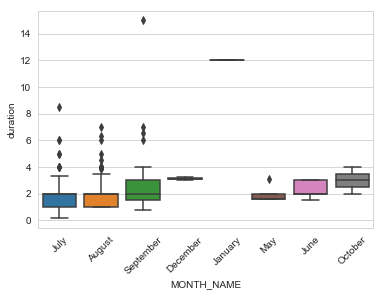

In [771]:
chart = sns.boxplot('MONTH_NAME','duration',data=my_data)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

In [781]:
#chart2 = sns.scatterplot(range(0,len(my_data.DAMAGE_PROPERTY)),'DAMAGE_PROPERTY',data=my_data)
my_data[my_data.DAMAGE_PROPERTY == np.max(my_data.DAMAGE_PROPERTY)]

,BEGIN_DAY,BEGIN_TIME,END_DAY,END_TIME,YEAR,MONTH_NAME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,...,FLOOD_CAUSE,BEGIN_RANGE,BEGIN_LOCATION,CZ_NAME,EPISODE_NARRATIVE,EVENT_NARRATIVE,begin_coords,end_coords,duration,flood_distance
382836,11,1215,11,1515,2012,September,0,0,0,0,...,Dam / Levee Break,1.0,SANTA CLARA,WASHINGTON,Monsoonal moisture interacted with a strong up...,An extended period of moderate to heavy rainfa...,"(37.13, -113.64)","(37.13, -113.64)",3.0,0.0


In [738]:
#p = sns.boxplot('MONTH_NAME','flood_distance',data=my_data,)
#p.set_xticklabels(chart.get_xticklabels(), rotation=45)

## Model Fitting 

In [739]:
#import necessary modules
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
import sklearn
from sklearn.preprocessing import StandardScaler

In [740]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score, accuracy_score

In [818]:
model_data = my_data.drop(columns=['begin_coords','end_coords','EVENT_NARRATIVE','EPISODE_NARRATIVE','DAMAGE_CROPS','BEGIN_TIME','END_TIME'])
model_data['large_prop_damage'] = model_data['DAMAGE_PROPERTY'] > 0 #classify "large" property damage as > $0
model_data = model_data.drop(columns=['DAMAGE_PROPERTY']) 
model_data.shape

(331, 16)

In [819]:
#separate data into target vector and x matrix 
X = model_data.iloc[:,0:14]
y = model_data.iloc[:,15]

In [820]:
#Need to encode strings as floats before fitting models (I'm using Label Encoding rather than One-Hot Encoding)
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
X = X.apply(le.fit_transform)



In [821]:
#split into training and test set 
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=12, test_size=.33,stratify=y)
#X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train,y_train,random_state=9, test_size=.33,stratify=y_train)

### Cross-Validation of Potential Models:

In [822]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC

LR = LogisticRegression(solver='liblinear')
NB = GaussianNB()
KNN = KNeighborsClassifier()
DT = DecisionTreeClassifier(max_depth=5)
RF = RandomForestClassifier(n_estimators=100)

In [823]:
scores = cross_validate(LR, X_train, y_train, cv=10,
                         scoring=('roc_auc', 'accuracy','recall'),
                        return_train_score=False)
np.mean(scores['test_accuracy'])

0.750686994165255

In [824]:
scores = cross_validate(NB, X_train, y_train, cv=10,
                         scoring=('roc_auc', 'accuracy','recall'),
                        return_train_score=False)
np.mean(scores['test_accuracy'])

0.7050536420101637

In [825]:
scores = cross_validate(KNN, X_train, y_train, cv=10,
                         scoring=('roc_auc', 'accuracy','recall'),
                        return_train_score=False)
np.mean(scores['test_accuracy'])

0.7341238471673254

In [826]:
scores = cross_validate(DT, X_train, y_train, cv=10,
                         scoring=('roc_auc', 'accuracy','recall'),
                        return_train_score=False)
np.mean(scores['test_accuracy'])

0.7146809712027103

In [827]:
scores = cross_validate(RF, X_train, y_train, cv=10,
                         scoring=('roc_auc', 'accuracy','recall'),
                        return_train_score=False)
np.mean(scores['test_accuracy'])

0.7515151515151516

In [828]:
#scores['test_accuracy']

In [829]:
#split into training and test set 
#Don't use this test set until the END of the problem after selecting the model
#X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=12, test_size=.33,stratify=y)
#X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train,y_train,random_state=9, test_size=.33,stratify=y_train)

The cross-validated accuracies are all pretty high, so I decided to fit all of them and compare the AUC for each model to decide which one I would pick. The reason I chose to compare the accuracies first is because it is one of the most intuitive metrics to interpret, so as a first interpretive metric I thought it would be good to use as a first idea of how the models might perform.

### Oversampling to Balance the Classes
There are 78 "large damage" floods and 253 "small damage" floods, so I'm going to try oversampling from the minority class to create a test and training set that are equal in class proportion. 

Oversampling is basically adding more copies of the minority class. Oversampling can be a good choice when you don’t have a ton of data to work with. (Source: https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d)


In [830]:
#from sklearn.utils import resample
# concatenate our training data back together
#X = pd.concat([X_train2, y_train2], axis=1)

# separate minority and majority classes
#large = X[X.large_prop_damage == True] #minority class
#small = X[X.large_prop_damage == False] #majority class


# upsample minority
#large_upsampled = resample(large,
#                          replace=True, # sample with replacement
#                          n_samples=len(small), # match number in majority class
#                          random_state=1234) 

# combine majority and upsampled minority
#upsampled = pd.concat([small, large_upsampled])

# check new class counts
#upsampled.large_prop_damage.value_counts()

In [831]:
#y_train = upsampled.large_prop_damage
#X_train = upsampled.drop('large_prop_damage', axis=1)


The reason that the oversampling code is commented out is because when I tried oversampling to equal out the class distributions, I calculated the AUC scores before and after and most of them decreased. I should note that the KNN accuracy did increase with the oversampling, as KNN generally performs better when there is no class imbalance, but it still was not as high as the Logistic Regression or Naive Bayes classifier. 

#### Label Encoding for Categorical Variables

I had a problem fitting the models before I remembered that Python has a difficult time processing levels of categorical variables, so I decided to use label encoders on the training and test sets

In [832]:
#Need to encode strings as floats before fitting models (I'm using Label Encoding rather than One-Hot Encoding)
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
X_train = X_train.apply(le.fit_transform)
#X_train2 = X_train2.apply(le.fit_transform)
X_test = X_test.apply(le.fit_transform)
#X_test2 = X_test2.apply(le.fit_transform)



## Model Fitting

I chose to use Logistic Regression, Naive Bayes, Decision Tree, and Random Forest models on this data. Logistic Regression and Naïve Bayes were chosen because the response is a binary classifier. These models are also some of the simplest and easiest models to interpret. Decision trees work well with categorical variables, but can be prone to overfitting (set a max_depth to combat this), so I wanted to compare the decision tree with the random forest model to see if a single tree could perform better than the forest, which usually isn't the case. Random forest was advantageous for its feature importance estimates and lower risk of overfitting. It is generally better than decision trees -- random sampling of training data points when building trees and random subsets of features considered when splitting nodes.

### Logistic Regression:

In [833]:
lr = LogisticRegression(solver='liblinear',class_weight='balanced') 
lr.fit(X_train2, y_train2)
y_lr = lr.predict(X_test)
prob_lr = lr.predict_proba(X_test)[:,1]

In [834]:
#AUC
lr_auc = roc_auc_score(y_test,prob_lr)
fpr_lr, tpr_lr, thresh = roc_curve(y_test, prob_lr)

### Naive Bayes:

In [835]:
nb = GaussianNB()
nb.fit(X_train2, y_train2)
y_nb = nb.predict(X_test)
prob_nb = nb.predict_proba(X_test)[:,1]

In [836]:
#AUC 
nb_auc = roc_auc_score(y_test,prob_nb)
fpr_nb, tpr_nb, thresh = roc_curve(y_test, prob_nb)


### Decision Tree:

In [837]:
tr = DecisionTreeClassifier(max_depth=5)
tr.fit(X_train, y_train)

yhat_tr = tr.predict(X_test)
prob_tr = tr.predict_proba(X_test)[:,1]
tr_acc = accuracy_score(y_test,yhat_tr)
tr_auc = roc_auc_score(y_test,yhat_tr)
fpr_tr, tpr_tr, thresh = roc_curve(y_test,prob_tr)


### Random Forest:

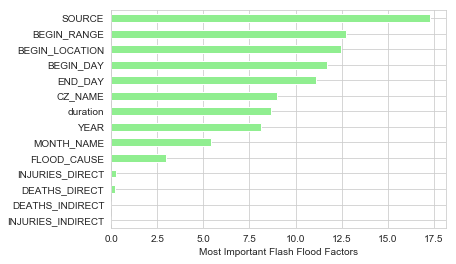

In [843]:
rf = RandomForestClassifier(n_estimators=100)
mod = rf.fit(X_train, y_train)
Importance = pd.DataFrame({'Importance':mod.feature_importances_*100}, index= X_train.columns)
#Importance = Importance.iloc[mod.feature_importances_ > 0:]
Importance = Importance.sort_values('Importance', axis=0, ascending=True)
Importance.plot(kind='barh', color='lightgreen', )
plt.xlabel('Most Important Flash Flood Factors')
plt.gca().legend_ = None


In [844]:
model_data.SOURCE.unique()

array(['Park/Forest Service', 'County Official',
       'Official NWS Observations', 'COOP Observer', 'Broadcast Media',
       'Newspaper', 'Trained Spotter', 'Public', 'CoCoRaHS',
       'Emergency Manager', 'Law Enforcement', 'State Official',
       'Department of Highways', 'Other Federal Agency', 'NWS Employee',
       'Utility Company', '911 Call Center'], dtype=object)

In [845]:
y_rf = rf.predict(X_test)
prob_rf = rf.predict_proba(X_test)[:,1]

rf_auc = roc_auc_score(y_test, prob_rf)
fpr_rf, tpr_rf, thresh = roc_curve(y_test, prob_rf)

## Select a Model:

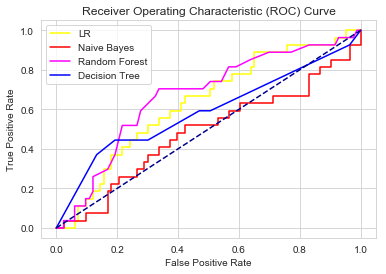

In [846]:
plt.plot(fpr_lr, tpr_lr, color='yellow', label='LR')
plt.plot(fpr_nb, tpr_nb, color='red', label='Naive Bayes')
plt.plot(fpr_rf,tpr_rf, color='magenta',label= 'Random Forest')
plt.plot(fpr_tr,tpr_tr, color='blue', label = 'Decision Tree')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

In [847]:
#Compare all the AUCs:
comp_auc = {"LR":lr_auc,"NB":nb_auc,"Tree":tr_auc,"RF":rf_auc}
comp_auc

{'LR': 0.6305220883534136,
 'NB': 0.4814814814814815,
 'Tree': 0.6017402945113789,
 'RF': 0.6671128960285587}

It appears that the Random Forest classifier has the highest AUC, which means it has a greater ability to separate the classes than the others. It would almost be just as good to randomly flip a coin to predict the classes for Naive Bayes. This is most likely due to the fact that I chose not to worry about the class imbalance as it was a relatively small dataset and I could get a pretty decent result with Random Forest and Logistic Regression as well. I decided to calculate the metrics for RF and LR, and choose between the two models. 

#### Calculate Other Metrics for Random Forest and Logistic Regression:

In [848]:
rf_acc = accuracy_score(y_test,y_rf)
rf_f1 = f1_score(y_test,y_rf)
rf_pre = precision_score(y_test,y_rf)
rf_rec = recall_score(y_test,y_rf)

lr_acc = accuracy_score(y_test,y_lr)
lr_f1 = f1_score(y_test,y_lr)
lr_pre = precision_score(y_test,y_lr)
lr_rec = recall_score(y_test,y_lr)

In [849]:
#logistic regression metrics: 
comp_lr = {"Accuracy":lr_acc,"F1":lr_f1,"Precision":lr_pre,"Recall":lr_rec}
#Random forest metrics:
comp_rf = {"Accuracy":rf_acc,"F1":rf_f1,"Precision":rf_pre,"Recall":rf_rec}

In [850]:
comp_lr

{'Accuracy': 0.6909090909090909,
 'F1': 0.31999999999999995,
 'Precision': 0.34782608695652173,
 'Recall': 0.2962962962962963}

In [852]:
comp_rf

{'Accuracy': 0.7090909090909091,
 'F1': 0.4666666666666667,
 'Precision': 0.42424242424242425,
 'Recall': 0.5185185185185185}

## Results and Conclusion

My first comment about this analysis is that I have a relatively small dataset, so it's pretty susceptible to variability in the various metrics after the random split. I tried first doing a train/test split on the training set, rather than cross-validation on the training set, to choose the model I wanted to use. Because my data is small, this led to a lower accuracy--likely due to a large proportion of classes being randomly placed in the training/test set than I would have preferred. I then tried to do a cross-validation and calculate the accuracy and AUC scores for the training set on all the models. This did increase the accuracy scores a bit, likely because that randomness factor was mitigated. The Random Forest model fit the best, which wasn't much of a surprise to me. Averaging a lot of decision trees logically seems like it would provide the highest accuracy score. Logistic regression also performed well, likely because it was a binary classifier and relatively small dataset.

## Limitations of Analysis and Further Questions

One limitation of this analysis is that I have a smaller dataset (331 rows) that may be prone to large differences in random train/test splits. I tried using cross-validation to overcome this issue, but the best solution would be to get more data. Another potential issue with this analysis is the class imbalance - 250 floods with no damage, and 81 floods with greater than zero dollars in damage -that might affect the classification metrics. We could expand our dataset to include floods from the US instead of just Utah, which likely would increase the runtime of the analysis. I tried oversampling from the minority class (property damage greater than zero) to combat the class imbalance, but it didn't seem to do much. I wonder if a larger dataset would have changed that. Another limitation is that it's hard to specify a logical cutoff value other than $0 of property damage, so I'm wondering if a regression analysis would have been more informative. A final limitation is that reading in the data takes a while – even with only a few CSV files from the web - so if there was a way to streamline this process that would make the analysis better. 